In [2]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV as gcv
import xgboost as xgb

# Set working path
path = '/Users/martinbogaert/Desktop/NBA Data Analysis/2022-2023 Awards Project clean/'

In [5]:
data = pd.read_csv(path + 'Algorithm/mip/mip_data.csv')
data['PTS_rel'] = [(pts-prev)/prev if prev > 0 else 0 for pts, prev in zip(data['PTS'], data['PTS_prev'])]
data['PER_rel'] = (data['PER'] - data['PER_prev']) / data['PER_prev']
data['PTS_high_diff'] = data['PTS'] - data['PTS_high']

In [184]:
# Separate features in three categories: current season, previous season and difference
cur, prev, diff = [], [], []
for feature in list(data) :
    if 'prev' in feature:
        prev.append(feature)
    elif 'diff' in feature:
        diff.append(feature)
    else :
        cur.append(feature)
  
prev.append('Share')
diff.append('Share')

In [185]:
def share_corr(fs) :
    corr_df = data[fs].corr().sort_values('Share', ascending = False)

    plt.figure(figsize = (16, 6))
    plt.bar(corr_df[corr_df['Share'] >= 0].index[1:], corr_df[corr_df['Share'] >= 0]['Share'][1:],
                        width = 0.6, color = 'darkorange', edgecolor = 'black')
    plt.bar(corr_df[corr_df['Share'] < 0].index, corr_df[corr_df['Share'] < 0]['Share'],
                        width = 0.6, color = 'red', edgecolor = 'black')

    plt.xticks(rotation = 80)
    plt.yticks(fontname = 'futura', size = 11)
    plt.ylabel('Correlation', fontname = 'futura', size = 14)
    plt.grid(axis = 'y')

    plt.show()

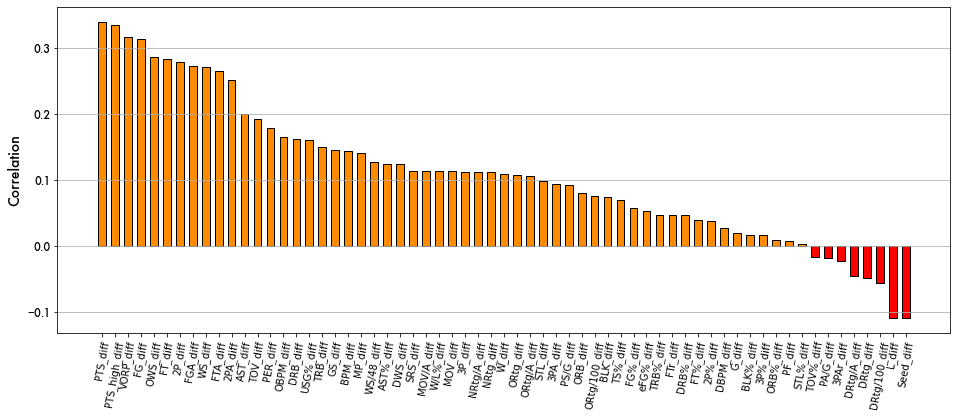

In [186]:
share_corr(diff)

In [246]:
features = ['PTS_high','FG','VORP','FGA','OWS','WS','MP','PER','TRB','AST','OBPM','USG%']
features = [f + '_diff' for f in features] + ['PER_rel','lifetime']

# Backtesting

In [247]:
years = np.arange(1998, 2023)
dfs = []

for year in years:
    
    print(f'Processing {year-1}-{year} season ...')
    clear_output(wait = True)
    
    X_train = data[data['Year'] < year]
    X_test = data[data['Year'] == year]
    
    model = RandomForestRegressor(n_estimators = 100, max_features = 'auto', min_samples_leaf = 2)
    model.fit(X_train[features], X_train['Share'])
    
    # Predict shares of test data
    pred = model.predict(X_test[features])
    X_test = X_test.assign(pred = pred)
    mse = mean_squared_error(pred, X_test['Share'])
    r2 = r2_score(pred, X_test['Share'])
    
    X_test['Rank'] = [len(X_test[X_test['Share'] > share])+1 for share in X_test['Share']] # Add rank
    X_test['Pred. rank'] = [len(X_test[X_test['pred'] > share])+1 for share in X_test['pred']] # Add predicted rank
    
    X_pred = X_test.sort_values('pred').tail(1)[['Year', 'Player', 'pred', 'Rank']].rename(columns = {'Player' : 'Pred. MIP'})
    X_test = X_test.sort_values('Share').tail(1)[['Year', 'Player', 'Share', 'Pred. rank']].rename(columns = {'Player' : 'MIP'})
    
    dfs.append(X_test.merge(X_pred, on = 'Year').assign(mse = mse, r2 = r2))

Processing 2021-2022 season ...


In [248]:
res = pd.concat(dfs)
res['correct'] = [True if act == pred else False for act, pred in zip(res['MIP'], res['Pred. MIP'])]
print('Accuracy :', round(100*res['correct'].mean(), 2), '%')
print('Mean squared error :', round(100*res['mse'].mean(), 3))
print('R2-score :', round(res['r2'].mean(), 3))
res.set_index('Year')

Accuracy : 24.0 %
Mean squared error : 0.462
R2-score : -5.466


,MIP,Share,Pred. rank,Pred. MIP,pred,Rank,mse,r2,correct
Year,,,,,,,,,
1998,Alan Henderson,0.284,4,Steve Nash,0.104162,17,0.002233,-4.350945,False
1999,Darrell Armstrong,0.458,1,Darrell Armstrong,0.064344,1,0.003836,-37.215491,True
2000,Jalen Rose,0.264,6,Dirk Nowitzki,0.199641,2,0.001795,0.087433,False
2001,Tracy McGrady,0.597,1,Tracy McGrady,0.264993,1,0.002741,-0.074454,True
2002,Jermaine O'Neal,0.413,11,Michael Redd,0.121250,9,0.002130,-5.792025,False
2003,Gilbert Arenas,0.488,4,Tony Parker,0.098698,4,0.004750,-12.458403,False
2004,Zach Randolph,0.626,2,Ronald Murray,0.142024,14,0.005263,-4.562336,False
2005,Bobby Simmons,0.624,6,Primož Brezec,0.220319,4,0.003647,-1.485649,False
2006,Boris Diaw,0.776,2,David West,0.268031,2,0.005192,-1.833286,False


# Visualising 2022 results

In [282]:
X_train = data[data['Year'] < 2022]
X_test = data[data['Year'] == 2022]

model = RandomForestRegressor(n_estimators = 100, max_features = 'auto', min_samples_leaf = 2)
model.fit(X_train[features], X_train['Share'])

# Predict shares of test data
pred = model.predict(X_test[features])
X_test = X_test.assign(pred = pred)

X_test['Rank'] = [len(X_test[X_test['Share'] > share])+1 for share in X_test['Share']] # Add rank
X_test['Pred. rank'] = [len(X_test[X_test['pred'] > share])+1 for share in X_test['pred']] # Add predicted rank

In [287]:
res_2022 = X_test.sort_values('Pred. rank')[['Player','Tm','Share', 'Rank', 'Pred. rank','pred']]

In [376]:
tm_col = {'ATL': '#e03a3e', 'BOS': 'green','BRK': 'gray','CHI': '#ce1141','CHO': 'aqua','CLE': 'maroon','DAL': 'cornflowerblue',
          'DEN': 'indigo','DET': 'royalblue','GSW': 'gold','HOU': 'lightcoral','IND': 'yellow','LAC': 'silver','LAL': '#fdb927','MEM': 'skyblue','MIA': 'hotpink',
          'MIL': '#00471b','MIN': 'lime','NOP': 'goldenrod','NYK': 'darkorange','OKC': 'dodgerblue','ORL': 'navy',
          'PHI': 'blue','PHO': 'orange','POR': '#cf0a2c','SAC': 'mediumslateblue','SAS': 'white','TOR': 'purple',
          'UTA': 'forestgreen','WAS': 'midnightblue'}

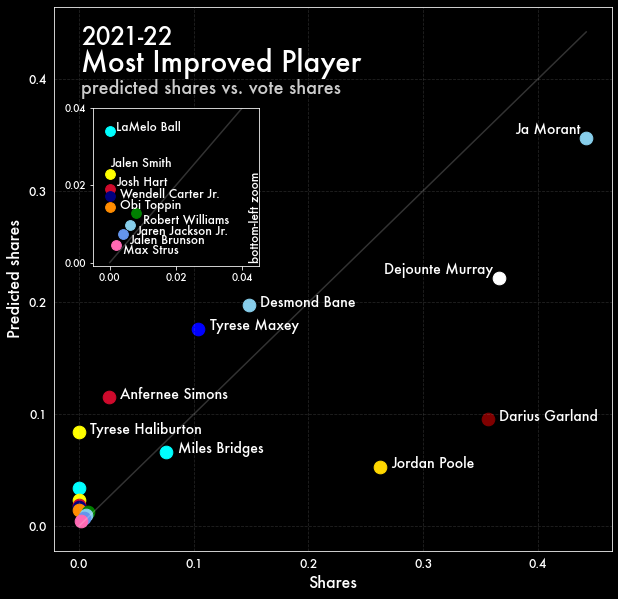

In [423]:
fig, ax = plt.subplots(figsize = (10, 10), facecolor = 'black')

plt.plot([0, max(res_2022['Share'].max(), res_2022['pred'].max())], [0, max(res_2022['Share'].max(), res_2022['pred'].max())], c = 'white', alpha = 0.2)

for player, share, pred, tm in zip(res_2022['Player'], res_2022['Share'], res_2022['pred'], res_2022['Tm']) :
    
    if pred > 0.0143 or share > 0:
        plt.scatter(share, pred, c = tm_col.get(tm), s = 160)
        
        if player == 'Ja Morant' or player == 'Dejounte Murray':
            plt.annotate(player, xy = (share - 0.005, pred), fontname = 'futura', color = 'white', size = 14, va = 'bottom', ha = 'right')
            
     #   elif player == 'Giannis Antetokounmpo':
        #    plt.annotate(player, xy = (share + 0.015, pred), fontname = 'futura', color = 'white', size = 14, va = 'top', ha = 'left')

        elif pred > 0.05 or share > 0.5 :
            plt.annotate(player, xy = (share + 0.01, pred - 0.005), fontname = 'futura', color = 'white', size = 14, va = 'bottom')
      
plt.ylabel('Predicted shares', color = 'white', size = 16, fontname = 'futura')
plt.xlabel('Shares', color = 'white', size = 16, fontname = 'futura')
plt.xticks(color = 'white', fontname = 'futura', size = 12)
plt.yticks(color = 'white', fontname = 'futura', size = 12)
plt.grid(linestyle = '--', alpha = 0.2)

### ANNOTATION ###
# Title
plt.annotate('2021-22', xy = (1/20, 0.93), fontname = 'futura', size = 24, xycoords = 'axes fraction', weight = 'bold', color = 'white') 
plt.annotate('Most Improved Player', xy = (1/20, 0.88), fontname = 'futura', size = 28, xycoords = 'axes fraction', weight = 'bold', color = 'white')
# Sub-title
plt.annotate('predicted shares vs. vote shares', xy = (1/20, 0.84), fontname = 'futura', size = 18, xycoords = 'axes fraction', color = 'white', alpha = 0.8)
# Signature
#plt.annotate('@      .', xy = (0.875, 0.16), fontname = 'futura', size = 14, alpha = 1, xycoords = 'axes fraction', color = 'white')
#plt.annotate('nba', xy = (0.9, 0.16), fontname = 'futura', size = 14, alpha = 1, xycoords = 'axes fraction', color = '#ff9000')
#plt.annotate('ai', xy = (0.95, 0.16), fontname = 'futura', size = 14, alpha = 1, xycoords = 'axes fraction', color = '#ff58c4')

ax.spines['left'].set_color('white'); ax.spines['right'].set_color('white')
ax.spines['bottom'].set_color('white'); ax.spines['top'].set_color('white')
ax_gca = plt.gca()
#plt.ylim([-0.01,0.7])
ax_gca.set_facecolor('black')

newax = fig.add_axes([0.18,0.52,0.23,0.22], zorder = 1)
newax.plot([0, 0.05], [0, 0.05], c = 'white', alpha = 0.2)

for player, share, pred, tm in zip(res_2022['Player'], res_2022['Share'], res_2022['pred'], res_2022['Tm']) :
    
    if share < 0.05 and pred < 0.05 :
        if share > 0 or pred > 0.0143 :
            newax.scatter(share, pred, c = tm_col.get(tm), s = 95)
            
            if player == 'Max Strus' or player == 'Jalen Brunson' or player == 'Robert Williams' or player == 'Jaren Jackson Jr.' :
                newax.annotate(player, xy = (share+0.002, pred), fontname = 'futura', color = 'white', size = 12, va = 'top')
            elif player == 'Wendell Carter Jr.' or player == 'Obi Toppin' :
                newax.annotate(player, xy = (share+0.003, pred+0.0005), fontname = 'futura', color = 'white', size = 12, va = 'center')
            elif player == 'Josh Hart' :
                newax.annotate(player, xy = (share+0.002, pred), fontname = 'futura', color = 'white', size = 12, va = 'bottom')
            elif player == 'Jalen Smith' :
                newax.annotate(player, xy = (share, pred+0.001), fontname = 'futura', color = 'white', size = 12, va = 'bottom')
            else :
                newax.annotate(player, xy = (share+0.002, pred), fontname = 'futura', color = 'white', size = 12)

newax.set_xticks([0, 0.02, 0.04])
newax.set_yticks([0, 0.02, 0.04])
newax.tick_params(colors = 'white')

labels = newax.get_xticklabels() + newax.get_yticklabels()
[label.set_fontname('futura') for label in labels]

newax.annotate('bottom-left zoom', xy = (0.94, 1/25), fontname = 'futura', size = 12, xycoords = 'axes fraction', color = 'white', rotation = 90) 
newax.spines['left'].set_color('white'); newax.spines['right'].set_color('white')
newax.spines['bottom'].set_color('white'); newax.spines['top'].set_color('white')
newax.set_xlim([-0.005, 0.045]); newax.set_ylim([-0.001, 0.04])
ax_gca = plt.gca()
ax_gca.set_facecolor('black')

plt.savefig(path + 'mip_2022_test.jpg', dpi = 300)
plt.show()

In [391]:
res_2022.head(15)

,Player,Tm,Share,Rank,Pred. rank,pred
2956,Ja Morant,MEM,0.442,1,1,0.346963
2924,Dejounte Murray,SAS,0.366,2,2,0.221557
2954,Desmond Bane,MEM,0.148,5,3,0.197523
2871,Tyrese Maxey,PHI,0.104,6,4,0.176631
2910,Anfernee Simons,POR,0.026,8,5,0.115366
2961,Darius Garland,CLE,0.356,3,6,0.095728
2893,Tyrese Haliburton,IND,0.000,13,7,0.084106
2937,Miles Bridges,CHO,0.076,7,8,0.066542
2909,Jordan Poole,GSW,0.262,4,9,0.052990
2936,LaMelo Ball,CHO,0.000,13,10,0.034163


In [8]:
jm = data[data['Year'] == 2022]

In [12]:
jm.nlargest(5, 'Share')[['Player', 'PTS_diff', 'VORP_diff', 'WS_diff', 'PER_diff']]

,Player,PTS_diff,VORP_diff,WS_diff,PER_diff
2956,Ja Morant,8.3,3.1,3.5,7.7
2924,Dejounte Murray,5.4,2.9,4.0,5.8
2961,Darius Garland,4.3,2.9,5.1,4.8
2909,Jordan Poole,6.5,1.3,4.1,1.0
2954,Desmond Bane,9.0,2.2,4.3,5.4
